# (MBTI) Myers-Briggs Personality Type Prediction


* Extroversion vs. Introversion
    * I - 0
    * E - 1 
    
* Sensing vs. Intuition 
    * N - 0 
    * S - 1
    
* Thinking vs. Feeling
    * F - 0
    * T - 1
    
* Judging vs. Perceiving
    * P - 0
    * J - 1 
    
## VISUALIZATIONS

In [1]:
# importing dependencies here
import pandas as pd

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# word cloud
from wordcloud import WordCloud
import re

# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# code formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# reading the dataset from step 3
personality_data = pd.read_csv("data_ekta/clean_data_3.csv")

<IPython.core.display.Javascript object>

### Word Clouds

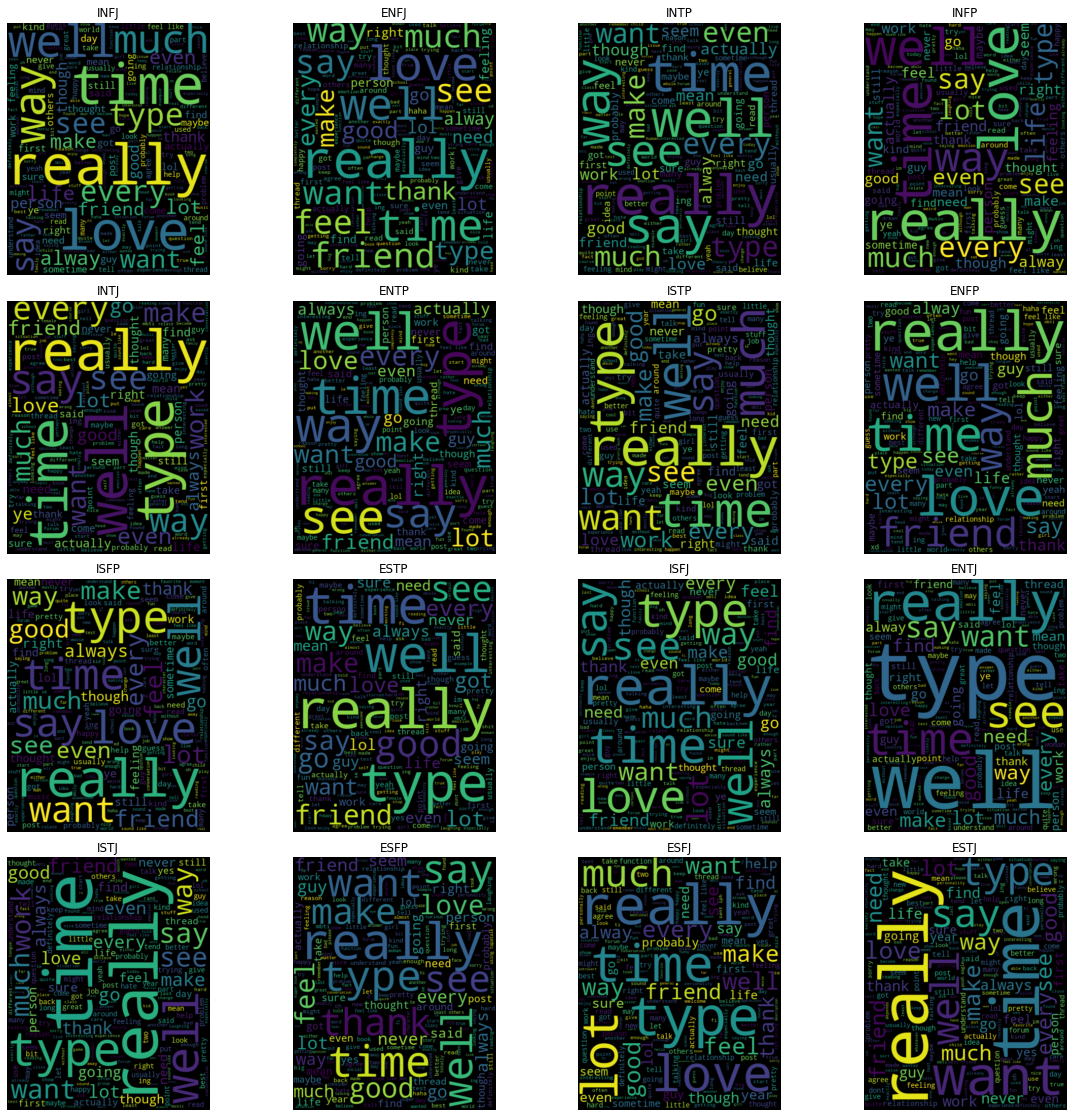

<IPython.core.display.Javascript object>

In [3]:
# creating word clouds for each of the 16 personality types

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax.ravel()

for i, mbti_type in enumerate(personality_data["type"].unique()):
    wordcloud_words = " ".join(
        [
            re.sub(r"(people)|(think)|(know)|(thing)|(one)", "", user_posts,)
            for user_posts in personality_data[personality_data["type"] == mbti_type][
                "clean_posts"
            ]
        ]
    )

    wordcloud = WordCloud(height=500).generate(wordcloud_words)
    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].axis("off")
    ax[i].set_title(mbti_type)

### COUNTS

#### Word Count by Type

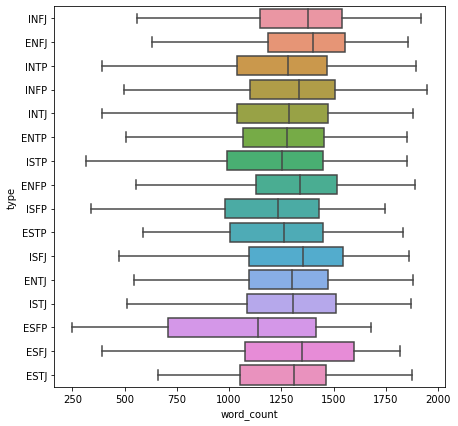

<IPython.core.display.Javascript object>

In [4]:
# boxplot of word counts
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="word_count", data=personality_data, showfliers=False)

#### Compound Sentiment Score by Type

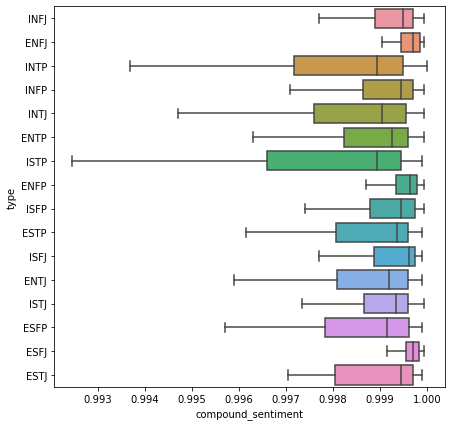

<IPython.core.display.Javascript object>

In [5]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="compound_sentiment", data=personality_data, showfliers=False)

#### Positive Sentiment Score by Type

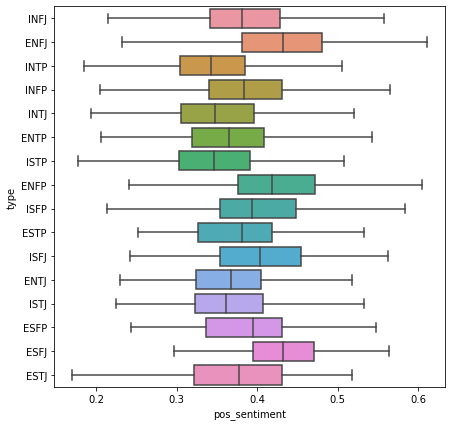

<IPython.core.display.Javascript object>

In [6]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="pos_sentiment", data=personality_data, showfliers=False)

#### Negative Sentiment Score by Type

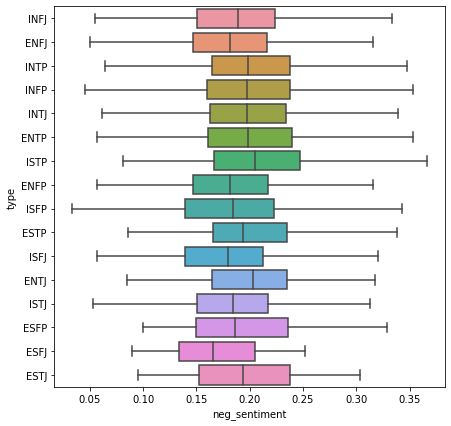

<IPython.core.display.Javascript object>

In [7]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="neg_sentiment", data=personality_data, showfliers=False)

#### Neutral Sentiment Score by Type

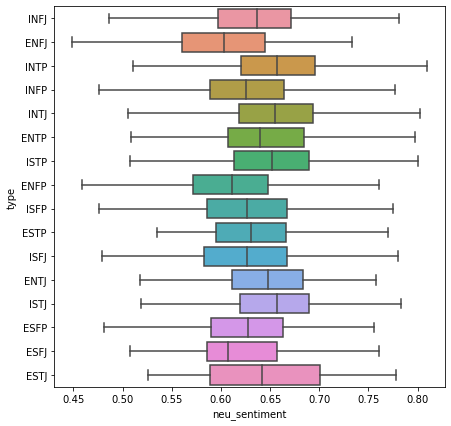

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="neu_sentiment", data=personality_data, showfliers=False)

#### Question Marks by Type

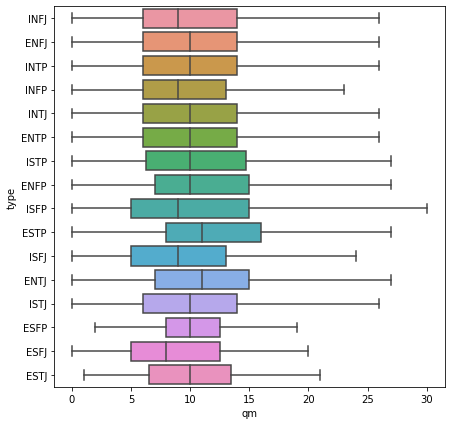

<IPython.core.display.Javascript object>

In [9]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="qm", data=personality_data, showfliers=False)

#### Exclamation by Type

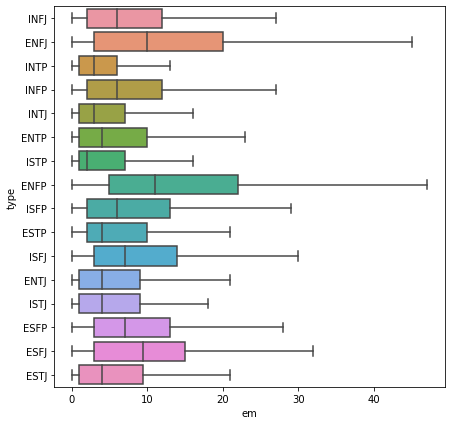

<IPython.core.display.Javascript object>

In [10]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="em", data=personality_data, showfliers=False)

#### Colons by Type

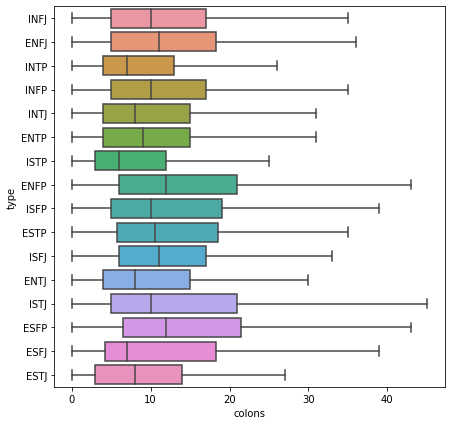

<IPython.core.display.Javascript object>

In [11]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="colons", data=personality_data, showfliers=False)

#### Emojis by Type

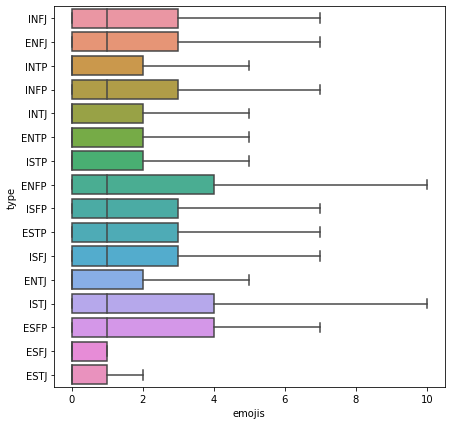

<IPython.core.display.Javascript object>

In [12]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="emojis", data=personality_data, showfliers=False)